In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten,UpSampling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
from PIL import Image
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
# enable this if pydot can be installed
!pip install pydot



In [ ]:
def build_generator(inputs, image_size):
    image_resize = image_size // 4
    kernel_size = 5

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2DTranspose(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)

In [ ]:
def build_discriminator(inputs):
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    x = inputs
    for filters in layer_filters:
            if filters == layer_filters[-1]:
                strides = 1
            else:
                strides = 2
    x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')

    discriminator.summary()
    return discriminator   

In [ ]:
def train(models, x_train, params):
    generator, discriminator, adversarial = models
    batch_size, latent_size, train_steps, model_name, image_size = params
    save_interval = 10
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    plot_input = np.random.uniform(-1.0, 1.0, size=[25, latent_size])

    dis_loss = []
    adver_loss = []
    dis_acc = []
    adver_acc = []




    train_size = x_train.shape[0]
    for i in range(train_steps):
        noise_to_d = np.random.normal(0, 2/(i+1), (batch_size, image_size, image_size, 1))
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes] + noise_to_d
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        fake_images = generator.predict(noise)
        
        x = np.concatenate((real_images, fake_images))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        
        loss, acc = discriminator.train_on_batch(x, y)
        dis_loss.append(loss)
        dis_acc.append(acc)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])
        
        loss, acc = adversarial.train_on_batch(noise, y)
        adver_loss.append(loss)
        adver_acc.append(acc)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        
        if (i + 1) % save_interval == 0:
            plot_images(generator,noise_input=plot_input,show=False,step=(i + 1),model_name=model_name)
            
    #generator.save(model_name + ".h5") 
    plot_acc(dis_acc,adver_acc)
    plot_loss(dis_loss, adver_loss)





In [ ]:
from google.colab import files
def plot_images(generator,noise_input,show=False,step=0,model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(5, 5))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')

    #plt.savefig(filename)
    plt.show()        
        

In [ ]:
def build_and_train_models():
    (x_train, _), (_, _) = fashion_mnist.load_data()

    image_size = x_train.shape[1]
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

    #x_train = x_train.astype('float32') / 255

    model_name = "dcgan_fashiomnist"
    latent_size = 100
    batch_size = 64
    train_steps = 100
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)

    inputs = Input(shape=(image_size, image_size, 1), name='discriminator_input')
    discriminator = build_discriminator(inputs)
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])
    discriminator.summary()
    plot_model(discriminator, to_file='dcgan-Fashion-Mnist-noise-to-discriminator.png', show_shapes=True)


    input_shape = (latent_size,)
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()
    plot_model(generator, to_file='dcgan-Fashion-Mnist-noise-to-D-generator.png', show_shapes=True)
    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    
    noise = np.random.normal(0, 5/train_steps, (batch_size, image_size))

    discriminator.trainable = False

    adversarial = Model(inputs, 
                           discriminator(generator(inputs)),
                            name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                            optimizer=optimizer,
                            metrics=['accuracy'])
    adversarial.summary()


    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name, image_size)
    train(models, x_train, params)    

In [ ]:
def plot_acc(dis_acc,adver_acc):
  #accuracy plot for training


  plt.plot(dis_acc)
  plt.plot(adver_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['discriminator', 'adversary'], loc='upper left')
  plt.show()


In [ ]:
def plot_loss(dis_loss, gen_loss):
  plt.plot(dis_loss)
  plt.plot(gen_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['discriminator', 'adversary'], loc='upper left')
  plt.show()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       6656      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 256)       0         
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 200705    
                                                                 
 activation_4 (Activation)   (None, 1)                 0         
                                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         856193    
                                                                 
Total params: 856,193
Trainable params: 855,809
Non-trainable params: 384
_________________________________________________________________
Model: "dcgan_fashiomnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_input (InputLayer)        [(None, 100)]             0         
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         856193    
                                                                 
 discriminator (Function

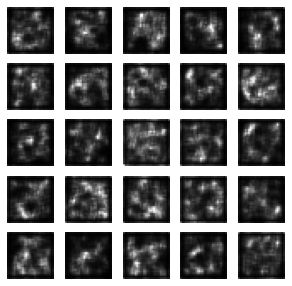

10: [discriminator loss: 0.005734, acc: 1.000000] [adversarial loss: 0.695032, acc: 0.656250]
11: [discriminator loss: 0.005489, acc: 1.000000] [adversarial loss: 0.633436, acc: 0.656250]
12: [discriminator loss: 0.005446, acc: 1.000000] [adversarial loss: 0.527485, acc: 0.734375]
13: [discriminator loss: 0.005335, acc: 1.000000] [adversarial loss: 0.557731, acc: 0.718750]
14: [discriminator loss: 0.005545, acc: 1.000000] [adversarial loss: 0.520167, acc: 0.765625]
15: [discriminator loss: 0.005773, acc: 1.000000] [adversarial loss: 0.492656, acc: 0.781250]
16: [discriminator loss: 0.006289, acc: 1.000000] [adversarial loss: 0.445544, acc: 0.812500]
17: [discriminator loss: 0.007400, acc: 1.000000] [adversarial loss: 0.486654, acc: 0.796875]
18: [discriminator loss: 0.008148, acc: 1.000000] [adversarial loss: 0.431577, acc: 0.843750]
19: [discriminator loss: 0.013364, acc: 1.000000] [adversarial loss: 0.394712, acc: 0.828125]


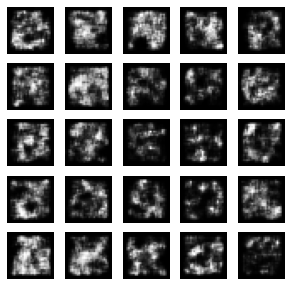

20: [discriminator loss: 0.019247, acc: 1.000000] [adversarial loss: 0.403504, acc: 0.843750]
21: [discriminator loss: 0.032028, acc: 1.000000] [adversarial loss: 0.434419, acc: 0.796875]
22: [discriminator loss: 0.048993, acc: 1.000000] [adversarial loss: 0.390384, acc: 0.890625]
23: [discriminator loss: 0.072945, acc: 0.984375] [adversarial loss: 0.471169, acc: 0.828125]
24: [discriminator loss: 0.092694, acc: 0.992188] [adversarial loss: 0.538770, acc: 0.781250]
25: [discriminator loss: 0.112022, acc: 0.984375] [adversarial loss: 0.605770, acc: 0.703125]
26: [discriminator loss: 0.121904, acc: 0.976562] [adversarial loss: 0.736963, acc: 0.640625]
27: [discriminator loss: 0.145615, acc: 0.968750] [adversarial loss: 0.822618, acc: 0.531250]
28: [discriminator loss: 0.112671, acc: 0.976562] [adversarial loss: 0.942631, acc: 0.484375]
29: [discriminator loss: 0.107083, acc: 0.992188] [adversarial loss: 0.986898, acc: 0.406250]


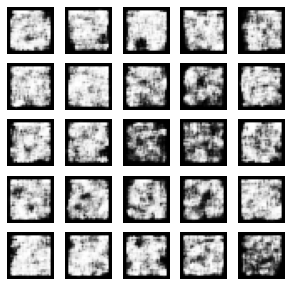

30: [discriminator loss: 0.070234, acc: 1.000000] [adversarial loss: 1.076528, acc: 0.437500]
31: [discriminator loss: 0.068190, acc: 1.000000] [adversarial loss: 1.063698, acc: 0.328125]
32: [discriminator loss: 0.085883, acc: 1.000000] [adversarial loss: 1.105899, acc: 0.187500]
33: [discriminator loss: 0.082186, acc: 1.000000] [adversarial loss: 1.151376, acc: 0.093750]
34: [discriminator loss: 0.059572, acc: 1.000000] [adversarial loss: 1.264725, acc: 0.109375]
35: [discriminator loss: 0.062681, acc: 1.000000] [adversarial loss: 1.346317, acc: 0.031250]
36: [discriminator loss: 0.049001, acc: 1.000000] [adversarial loss: 1.379669, acc: 0.000000]
37: [discriminator loss: 0.044367, acc: 1.000000] [adversarial loss: 1.378332, acc: 0.000000]
38: [discriminator loss: 0.064825, acc: 1.000000] [adversarial loss: 1.535590, acc: 0.000000]
39: [discriminator loss: 0.041639, acc: 1.000000] [adversarial loss: 1.516465, acc: 0.015625]


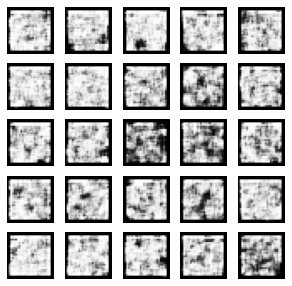

40: [discriminator loss: 0.043734, acc: 1.000000] [adversarial loss: 1.536057, acc: 0.000000]
41: [discriminator loss: 0.036745, acc: 1.000000] [adversarial loss: 1.500189, acc: 0.000000]
42: [discriminator loss: 0.028084, acc: 1.000000] [adversarial loss: 1.427634, acc: 0.000000]
43: [discriminator loss: 0.032102, acc: 1.000000] [adversarial loss: 1.425681, acc: 0.000000]
44: [discriminator loss: 0.029515, acc: 1.000000] [adversarial loss: 1.456620, acc: 0.000000]
45: [discriminator loss: 0.037954, acc: 1.000000] [adversarial loss: 1.578256, acc: 0.000000]
46: [discriminator loss: 0.038024, acc: 1.000000] [adversarial loss: 1.703953, acc: 0.000000]
47: [discriminator loss: 0.040031, acc: 1.000000] [adversarial loss: 1.826545, acc: 0.000000]
48: [discriminator loss: 0.037662, acc: 1.000000] [adversarial loss: 1.917094, acc: 0.000000]
49: [discriminator loss: 0.035225, acc: 1.000000] [adversarial loss: 1.900898, acc: 0.000000]


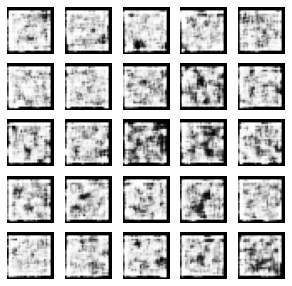

50: [discriminator loss: 0.023635, acc: 1.000000] [adversarial loss: 1.779608, acc: 0.000000]
51: [discriminator loss: 0.025499, acc: 1.000000] [adversarial loss: 1.724381, acc: 0.000000]
52: [discriminator loss: 0.022206, acc: 1.000000] [adversarial loss: 1.722834, acc: 0.000000]
53: [discriminator loss: 0.025504, acc: 1.000000] [adversarial loss: 1.802274, acc: 0.000000]
54: [discriminator loss: 0.026645, acc: 1.000000] [adversarial loss: 1.926434, acc: 0.000000]
55: [discriminator loss: 0.027179, acc: 1.000000] [adversarial loss: 2.144772, acc: 0.000000]
56: [discriminator loss: 0.030465, acc: 1.000000] [adversarial loss: 2.409913, acc: 0.000000]
57: [discriminator loss: 0.025206, acc: 1.000000] [adversarial loss: 2.679424, acc: 0.000000]
58: [discriminator loss: 0.021764, acc: 1.000000] [adversarial loss: 2.911360, acc: 0.000000]
59: [discriminator loss: 0.019249, acc: 1.000000] [adversarial loss: 3.153586, acc: 0.000000]


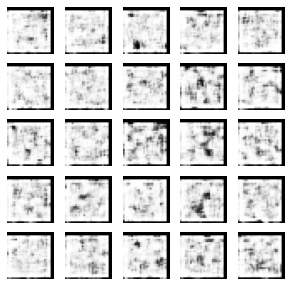

60: [discriminator loss: 0.015929, acc: 1.000000] [adversarial loss: 3.332096, acc: 0.000000]
61: [discriminator loss: 0.013952, acc: 1.000000] [adversarial loss: 3.454837, acc: 0.000000]
62: [discriminator loss: 0.011888, acc: 1.000000] [adversarial loss: 3.577767, acc: 0.000000]
63: [discriminator loss: 0.010922, acc: 1.000000] [adversarial loss: 3.685095, acc: 0.000000]
64: [discriminator loss: 0.009757, acc: 1.000000] [adversarial loss: 3.836385, acc: 0.000000]
65: [discriminator loss: 0.008462, acc: 1.000000] [adversarial loss: 3.995973, acc: 0.000000]
66: [discriminator loss: 0.007597, acc: 1.000000] [adversarial loss: 4.162280, acc: 0.000000]
67: [discriminator loss: 0.006726, acc: 1.000000] [adversarial loss: 4.329433, acc: 0.000000]
68: [discriminator loss: 0.006035, acc: 1.000000] [adversarial loss: 4.497036, acc: 0.000000]
69: [discriminator loss: 0.005223, acc: 1.000000] [adversarial loss: 4.666677, acc: 0.000000]


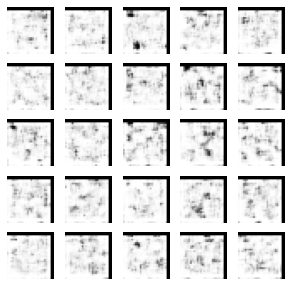

70: [discriminator loss: 0.099956, acc: 0.992188] [adversarial loss: 3.546413, acc: 0.000000]
71: [discriminator loss: 0.013704, acc: 1.000000] [adversarial loss: 3.831736, acc: 0.000000]
72: [discriminator loss: 0.011162, acc: 1.000000] [adversarial loss: 4.080293, acc: 0.000000]
73: [discriminator loss: 0.008690, acc: 1.000000] [adversarial loss: 4.287448, acc: 0.000000]
74: [discriminator loss: 0.007198, acc: 1.000000] [adversarial loss: 4.464761, acc: 0.000000]
75: [discriminator loss: 0.005969, acc: 1.000000] [adversarial loss: 4.626477, acc: 0.000000]
76: [discriminator loss: 0.005036, acc: 1.000000] [adversarial loss: 4.751983, acc: 0.000000]
77: [discriminator loss: 0.004373, acc: 1.000000] [adversarial loss: 4.863147, acc: 0.000000]
78: [discriminator loss: 0.003904, acc: 1.000000] [adversarial loss: 5.002737, acc: 0.000000]
79: [discriminator loss: 0.003408, acc: 1.000000] [adversarial loss: 5.113142, acc: 0.000000]


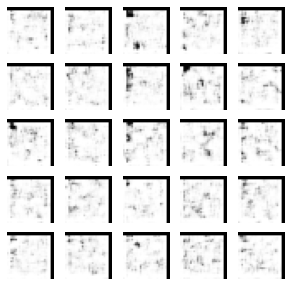

80: [discriminator loss: 0.003140, acc: 1.000000] [adversarial loss: 5.193758, acc: 0.000000]
81: [discriminator loss: 0.002799, acc: 1.000000] [adversarial loss: 5.260212, acc: 0.000000]
82: [discriminator loss: 0.002723, acc: 1.000000] [adversarial loss: 5.329401, acc: 0.000000]
83: [discriminator loss: 0.002512, acc: 1.000000] [adversarial loss: 5.434111, acc: 0.000000]
84: [discriminator loss: 0.002352, acc: 1.000000] [adversarial loss: 5.491937, acc: 0.000000]
85: [discriminator loss: 0.002161, acc: 1.000000] [adversarial loss: 5.577066, acc: 0.000000]
86: [discriminator loss: 0.002010, acc: 1.000000] [adversarial loss: 5.621938, acc: 0.000000]
87: [discriminator loss: 0.001880, acc: 1.000000] [adversarial loss: 5.721337, acc: 0.000000]
88: [discriminator loss: 0.001730, acc: 1.000000] [adversarial loss: 5.760343, acc: 0.000000]
89: [discriminator loss: 0.001547, acc: 1.000000] [adversarial loss: 5.778608, acc: 0.000000]


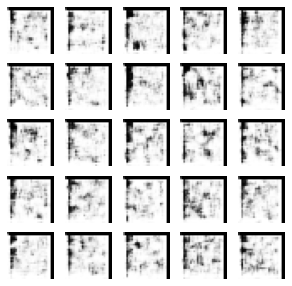

90: [discriminator loss: 0.001514, acc: 1.000000] [adversarial loss: 5.806276, acc: 0.000000]
91: [discriminator loss: 0.001471, acc: 1.000000] [adversarial loss: 5.815814, acc: 0.000000]
92: [discriminator loss: 0.001397, acc: 1.000000] [adversarial loss: 5.872379, acc: 0.000000]
93: [discriminator loss: 0.001340, acc: 1.000000] [adversarial loss: 5.937836, acc: 0.000000]
94: [discriminator loss: 0.001235, acc: 1.000000] [adversarial loss: 5.962660, acc: 0.000000]
95: [discriminator loss: 0.001170, acc: 1.000000] [adversarial loss: 5.956712, acc: 0.000000]
96: [discriminator loss: 0.001143, acc: 1.000000] [adversarial loss: 5.796850, acc: 0.000000]
97: [discriminator loss: 0.001136, acc: 1.000000] [adversarial loss: 5.507926, acc: 0.000000]
98: [discriminator loss: 0.001264, acc: 1.000000] [adversarial loss: 4.936558, acc: 0.000000]
99: [discriminator loss: 0.001829, acc: 1.000000] [adversarial loss: 4.382058, acc: 0.000000]


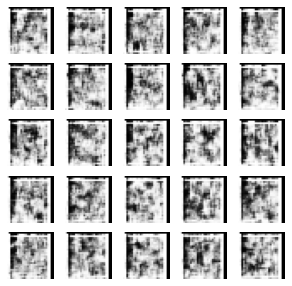

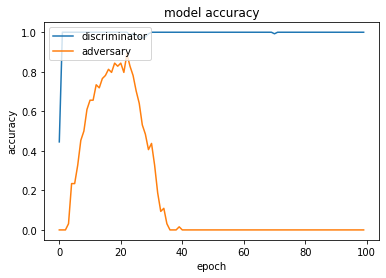

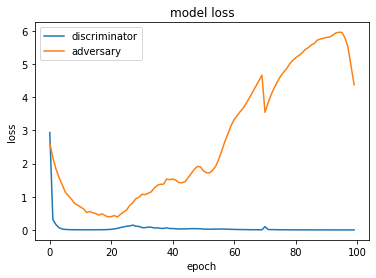

In [ ]:
build_and_train_models() 